# Step-by-step to your first linear regression model

1. We download data 🗂
2. We talk the math
3. Define and compute the loss function
4. Optimize parameters by computing the gradient
5. Change parameters in a loop according to the gradients
6. Validate :)

We use JAX in this tutorial `pip install jax`

### 1. Get data (you know)

- We use pandas and load the tendency to crystallize of polymers dataset from GitHub lecture 2
- Out model should learn how to compute the tendency to crystallize (`value`) from the fingerprints


In [27]:
import pandas as pd

df = pd.read_json(
    "https://raw.githubusercontent.com/kuennethgroup/colab_tutorials/main/lecture2/data/polymers_tend_to_crystalize.json"
)
df

,smiles,property,value,fingerprint
0,[*]C[*],Xc,47.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,[*]CC([*])C,Xc,44.47,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[*]CC([*])CC,Xc,34.04,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[*]CC([*])CCC,Xc,20.01,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[*]CC([*])CC(C)C,Xc,21.64,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
427,[*]C([*])(F)F,Xc,31.84,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
428,[*]C/C=C\C[*],Xc,25.58,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
429,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(N=Cc3ccc...,Xc,29.05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
430,[*]O[Si](C)(C)CCCC(=O)Oc1ccc(C=Nc2ccc(Cc3ccc(N...,Xc,21.74,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


### 2. Math and model

Our model is defined as

$$
X = \sum \left(\mathbf{w} \vec{f} + \vec{b}\right)
$$


$\mathbf{w}$ ... a matrix (2d array) of adjustable parameters (weights)

$\vec{b}$ ... a vector of adjustable parameters (bias)

$\vec{f}$ ... fingerprint, feature, descriptor, or input vector

$X$ ... output vector, prediction, here tendency to crystalize of polymers

*Note*: Because the tendency to crystallize is a scalar, we use the sum as "pooling" operation at 


In [28]:
# !pip install -U "jax[cpu]"
import jax.numpy as jnp
import numpy as np

np.random.seed(10)


def simple_model(f, w, b):
    return jnp.sum(jnp.dot(w, f) + b)


# Let's test it
f = jnp.array(np.random.rand(3))
print(f"{f = }")
w = jnp.array(np.random.rand(1, 3))
print(f"{w = }")
b = jnp.array(np.random.rand(3))
print(f"{b = }")

simple_model(f, w, b)

f = Array([0.77132064, 0.02075195, 0.6336482 ], dtype=float32)
w = Array([[0.74880385, 0.49850702, 0.22479665]], dtype=float32)
b = Array([0.19806287, 0.7605307 , 0.16911083], dtype=float32)


Array(3.318769, dtype=float32)

### 3. Compute the loss for one data point

We use the mean squared error (MSE) for this 
$$
\text{MSE} = L = \frac{1}{N} \sum_i^N \left( y_i - \hat{y}_i\right)^2
$$
$y_i$ are the true values; $\hat{y}_i$ are the predictions;

In our case
$$
\text{MSE} = L = \frac{1}{N} \sum_i^N \left( X_i - m(f_i,\mathbf{w}, \vec{b})\right)^2
$$

In [29]:
# Get the one fingerprint and test our model
xc_array = jnp.array(df["value"].values)
f_array = jnp.array(np.vstack(df["fingerprint"].values))

# Initialize w and b randomly
# randn draws values from a standard normal distribution
extra_dim = 1
w = jnp.array(np.random.randn(extra_dim, f_array.shape[1]))
b = jnp.array(np.random.randn(extra_dim))


# Get the prediction
xc_predict = simple_model(f_array[0], w, b)


# We need a loss function that tells us how good or bad our model is
def loss(xc_truth, xc_predict):
    return jnp.mean((xc_truth - xc_predict) ** 2)


# Compute the loss
loss(xc_array[0], xc_predict)

Array(2041.3823, dtype=float32)

### 4. Optimize $\mathbf{w}$ and $\vec{b}$ by gradients

Optimize by computing the derivatives of $L$ with respect to $\mathbf{w}$ and $\vec{b}$.
$$
\frac{\partial L} {\partial w_{ij}}, \frac{\partial L} {\partial b_i},
$$

and reducing the loss by taking a step in the negative gradient direction
$$
w_{ij}' = w_{ij} - \eta \frac{\partial L} {\partial w_{ij}},
$$
and
$$
b_i' = b_i - \eta \frac{\partial L} {\partial b_i},
$$

$\eta$ is the learning rate.

In [30]:
import jax


# Wrapper
def predict_and_loss_wrapper(w, b, xc, f):
    xc_predict = simple_model(f, w, b)
    return loss(xc, xc_predict)


# Build the gradient function with JAX of prediction and loss
grad_func = jax.grad(predict_and_loss_wrapper, (0, 1))


# Test
grads_w, grads_b = grad_func(w, b, xc_array[0], f_array[0])
print(f"{grads_w = }")
print(f"{grads_w.sum() = }")
print(f"{grads_b = }")
print(f"{grads_b.sum() = }")

grads_w = Array([[-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)
grads_w.sum() = Array(-542.17993, dtype=float32)
grads_b = Array([-90.36332], dtype=float32)
grads_b.sum() = Array(-90.36332, dtype=float32)


### 5. Iteratively optimize $\mathbf{w}$ and $\vec{b}$


In neural networks, this is called back-propagation


Text(0, 0.5, 'MSE loss')

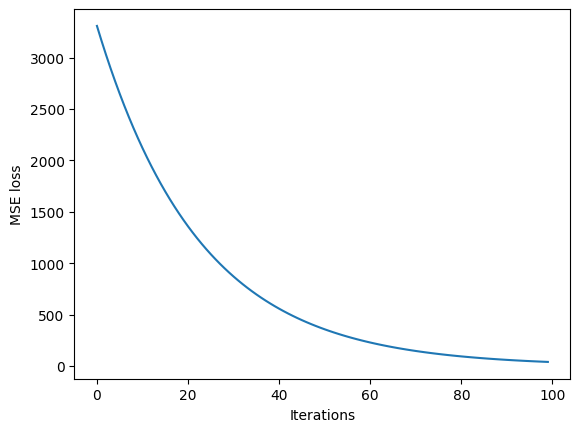

In [36]:
import matplotlib.pyplot as plt

# set seed
np.random.seed(10)

# get all values from the dataframe
xc_array = jnp.array(df["value"].values)
f_array = jnp.array(np.vstack(df["fingerprint"].values))

# Initialize w and b randomly
extra_dim = 10
w = jnp.array(np.random.randn(extra_dim, f_array.shape[1]))
b = jnp.array(np.random.randn(extra_dim))

# Save this for later
b_init = b.copy()
w_init = w.copy()


eta = 1e-4  # learning rate 
losses = []
for i in range(100):
    grads_w, grads_b = grad_func(w, b, xc_array[0], f_array[0])
    w -= eta * grads_w
    b -= eta * grads_b
    my_loss = predict_and_loss_wrapper(w, b, xc_array[0], f_array[0])
    losses.append(my_loss)

plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("MSE loss")

### 6. Validate

In [55]:
# Test with w and b
print(
    f"Init   {simple_model(f_array[0], w_init, b_init).tolist() = }  \n"
    f"Optim  {simple_model(f_array[0], w, b).tolist() = }  \n"
    f"Truth  {xc_array[0] = }"
)

Init   simple_model(f_array[0], w_init, b_init).tolist() = -11.005064964294434  
Optim  simple_model(f_array[0], w, b).tolist() = 41.442298889160156  
Truth  xc_array[0] = Array(47.8, dtype=float32)


### 